In [32]:
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import time

In [33]:
# Load the data
raw_data = pd.DataFrame(pd.read_csv('../data/merged_data.csv'))
raw_data = raw_data.drop("Unnamed: 0", axis=1)

In [34]:
raw_data

,CCS,Ion mobility index,sequence,charge,dt,mass_mean
0,5.996674e-36,156,AAAAAAAAAK,1,111.248,785.944876
1,5.956918e-36,147,AAAAAAAAAK,1,111.248,785.944876
2,5.996673e-36,156,AAAAAAAAAK,1,111.248,785.944876
3,5.970114e-36,150,AAAAAAAAAK,1,111.248,785.944876
4,5.996675e-36,156,AAAAAAAAAK,1,111.248,785.944876
...,...,...,...,...,...,...
157014,3.109287e-35,729,YYVTIIDAPGHR,3,33.270,1404.225025
157015,3.109287e-35,729,YYVTIIDAPGHR,3,33.276,1404.224925
157016,1.631641e-35,522,YYWDIDLDNCVAR,2,63.229,1702.251255
157017,1.631641e-35,522,YYWDIDLDNCVAR,2,63.877,1702.250505


In [42]:
raw_data['CCS_z'] = stats.zscore(raw_data['CCS'])
raw_data['dt_z'] = stats.zscore(raw_data['dt'])
data_clean = raw_data.sample(frac=1, random_state=1)

# Save the mean and std for later use
ccs_mean = data_clean['CCS'].mean()
ccs_std = data_clean['CCS'].std()

dt_mean = data_clean['dt'].mean()
dt_std = data_clean['dt'].std()

In [36]:
data_clean

,CCS,Ion mobility index,sequence,charge,dt,mass_mean,CCS_z,dt_z
62120,1.665055e-35,540,IGNLQTDLSDGLR,2,55.165,1401.231280,-0.586895,-0.097876
80664,1.921626e-35,666,LIDFLECGK,2,39.820,1094.053540,-0.141751,-1.184325
30419,1.691294e-35,555,EGLELPEDEEEK,2,54.438,1416.136290,-0.541372,-0.149349
103315,1.511284e-35,444,NPELQNLLLDDFFK,2,68.907,1705.376495,-0.853686,0.875078
90561,1.588573e-35,495,LVINGNPITIFQER,2,61.269,1613.395045,-0.719591,0.334296
...,...,...,...,...,...,...,...,...
73349,2.639245e-35,594,LAMQEFMILPVGAANFR,3,49.181,1923.481980,1.103303,-0.521553
109259,1.808395e-35,615,QLDECASAITK,2,46.834,1235.091375,-0.338203,-0.687724
50057,1.778468e-35,600,GIVLLEELLPK,2,50.354,1223.260690,-0.390127,-0.438502
5192,1.679774e-35,549,AGGIETIANEYSDR,2,54.972,1495.201375,-0.561359,-0.111541


In [44]:
X = data_clean[["charge", 'mass_mean','Ion mobility index','CCS_z']]
y = data_clean['dt_z']

In [45]:
from sklearn.ensemble import RandomForestRegressor
k=4
n=20
# Start logging time in ms without
start_time = time.time()
# Initialize the cross-validation object
kf = KFold(n_splits=k)
# Initialize a list to store the MSE for each fold
mse_scores = []
median_relative_errors = []
r2_scores = []
# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Create a random forest regressor model
    model = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predictions back to original scale
    y_pred_orig = y_pred * dt_std + dt_mean
    y_test_orig = y_test * dt_std + dt_mean

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mse_scores.append(mse)
    # Calculate the median relative error for the current fold
    relative_errors = np.abs((y_pred_orig - y_test_orig) / y_test_orig)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)
    # Calculate the R^2 score for the current fold
    r2 = r2_score(y_test_orig, y_pred_orig)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

# Create the final model
final_model = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
final_model.fit(X, y)

# Print the average MSE score
print("Average Mean Squared Error:", np.mean(mse_scores))
# print the average of the median relative errors
print("Average Median Relative Error:", np.mean(median_relative_errors))
# Print the average R^2 score
print("Average R^2 Score:", np.mean(r2_scores))
# Calculate the elapsed time
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.7530190128712742
Average Median Relative Error: 0.0013551304495013508
Average R^2 Score: 0.9962282775842504
Time elapsed: 18.27 seconds


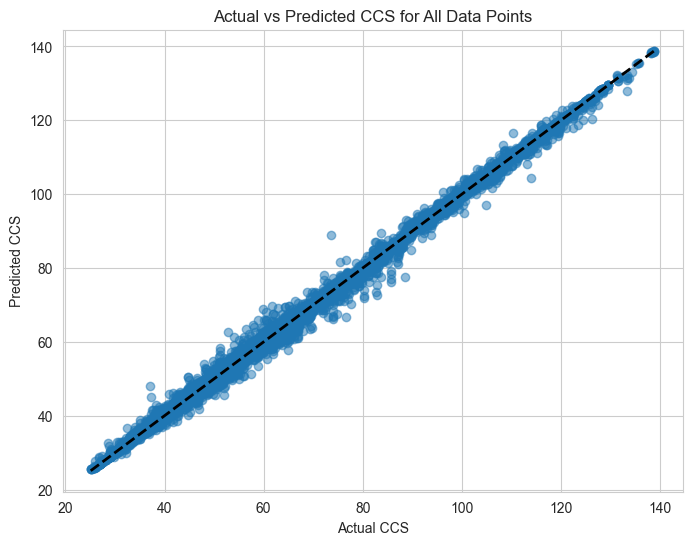

In [46]:
import matplotlib.pyplot as plt
# Make predictions on the entire dataset
y_pred_all = final_model.predict(X)

# Convert predictions back to original scale
y_pred_all_orig = y_pred_all * dt_std + dt_mean
y_all_orig = y * dt_std + dt_mean

# Scatter plot of actual vs. predicted CCS for all data points
plt.figure(figsize=(8, 6))
plt.scatter(y_all_orig, y_pred_all_orig, alpha=0.5)
plt.plot([y_all_orig.min(), y_all_orig.max()], [y_all_orig.min(), y_all_orig.max()], 'k--', lw=2)
plt.xlabel('Actual CCS')
plt.ylabel('Predicted CCS')
plt.title('Actual vs Predicted CCS for All Data Points')
plt.show()

In [ ]:
data_clean.plot.scatter(x='CCS_z',
                      y='charge',
                      c='DarkBlue')